In [1]:
import warnings
warnings.filterwarnings('ignore') # Filter out warnings
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from scipy import stats
import math
from math import isnan
# loading machine learning required packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import time
# for multi-class logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
## counter
from collections import Counter
from random import *

C:\Users\Aaron\Anaconda3\envs\data-x\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Aaron\Anaconda3\envs\data-x\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
file_path_1 = "Messages_allDay_AMZN_withY.csv"
file_path_2 = "Messages_allDay_GOOG_withY.csv"
file_path_3 = "Messages_allDay_AAPL_withY.csv"
df_AMZN = pd.read_csv(file_path_1)
df_GOOG = pd.read_csv(file_path_2)
df_AAPL = pd.read_csv(file_path_3)
# drop useless columns
df_AMZN = df_AMZN.drop(columns=['Unnamed: 0'])
df_GOOG = df_GOOG.drop(columns=['Unnamed: 0'])
df_AAPL = df_AAPL.drop(columns=['Unnamed: 0'])
# stack them to a dictionary
Stocks = {'AMZN':df_AMZN,'GOOG':df_GOOG,'AAPL':df_AAPL}

In [3]:
df_AMZN.head(5)

,Time_stamp,Type,OrderID,V,Dir,Time,V_ask_1,V_bid_1,V_ask_2,V_bid_2,...,mid-price 2_,bid-ask spread 3_,mid-price 3_,bid-ask spread 4_,mid-price 4_,bid-ask spread 5_,mid-price 5_,Mid_price,MidPrice_Moves,SpdCros_Moves
0,34200.18961,1,11885113,21,1,30:00.2,100,21,100,100,...,223.585,0.93,223.535,1.21,223.645,1.40,223.700,223.88,2,2
1,34200.18961,1,3911376,20,-1,30:00.2,100,21,20,100,...,223.570,0.92,223.530,0.96,223.520,1.25,223.625,223.88,2,2
2,34200.18961,1,11534792,100,1,30:00.2,100,21,20,100,...,223.855,0.81,223.585,0.93,223.535,1.21,223.645,223.88,2,2
3,34200.18961,1,1365373,13,-1,30:00.2,100,21,20,100,...,223.855,0.81,223.585,0.93,223.535,1.21,223.645,223.88,2,2
4,34200.18961,1,11474176,2,1,30:00.2,100,21,20,100,...,223.855,0.34,223.820,0.82,223.590,1.18,223.660,223.88,2,2


In [4]:
df_AMZN.columns

Index(['Time_stamp', 'Type', 'OrderID', 'V', 'Dir', 'Time', 'V_ask_1',
       'V_bid_1', 'V_ask_2', 'V_bid_2', 'V_ask_3', 'V_bid_3', 'V_ask_4',
       'V_bid_4', 'V_ask_5', 'V_bid_5', 'Label', 'Level', 'Mean_V_ask',
       'Mean_V_bid', 'V_accu', 'P_', 'P_ask_1_', 'P_bid_1_', 'P_ask_2_',
       'P_bid_2_', 'P_ask_3_', 'P_bid_3_', 'P_ask_4_', 'P_bid_4_', 'P_ask_5_',
       'P_bid_5_', 'bid-ask spread 1_', 'mid-price 1_', 'd_P_ask_51_',
       'd_P_bid_51_', 'd_P_ask_21_', 'd_P_bid_21_', 'd_P_ask_32_',
       'd_P_bid_32_', 'd_P_ask_43_', 'd_P_bid_43_', 'd_P_ask_54_',
       'd_P_bid_54_', 'Mean_P_ask_', 'Mean_P_bid_', 'P_accu_',
       'bid-ask spread 2_', 'mid-price 2_', 'bid-ask spread 3_',
       'mid-price 3_', 'bid-ask spread 4_', 'mid-price 4_',
       'bid-ask spread 5_', 'mid-price 5_', 'Mid_price', 'MidPrice_Moves',
       'SpdCros_Moves'],
      dtype='object')

### loop through all hours in the trading day, plot accuracy, with a lot shortened training set.

In [5]:
def PredictY_balancedTrainingSet(tradingDay_df,trainingTime_mins,nEvents,target_Y,C_param):
     ## return two things:
    train_accs, test_accs = [], []
    # make a copy of the dataframe
    df = tradingDay_df.copy(deep=False)
    st_time,ed_time  = int(list(df['Time_stamp'])[0]), int(list(df['Time_stamp'])[-1])  # in seconds
    ## st: denote the start time of each training session; lag: how much time allowed to fetch from the future
    lag = 5
    st, ed = st_time, st_time + trainingTime_mins*60
    # when last prediction time is not beyond the total trading time window
    while (ed+lag*60<=ed_time):
        # 1) original training set
        train = df[(df['Time_stamp']>=st)&(df['Time_stamp']<ed)]
        # extract observations in training set, where y = 0/1/2
        train_y0 = train[(train[target_Y]==0)]
        train_y1 = train[(train[target_Y]==1)]
        train_y2 = train[(train[target_Y]==2)]
        # want to keep y0:y1:y2 = 1:1:2
        avg_y0y1 = int(float(train_y0.shape[0] + train_y1.shape[1])/2)
        train_y2_new = train_y2.sample(avg_y0y1*2)
        # concat the dataframe to make a new training set
        train_new = pd.concat([train_y0,train_y1,train_y2_new])
        # 2) use next nEvents to define testing set
        idx = int(df[(df['Time_stamp']>=ed)].head(1).index.values)
        test = df.iloc[idx+train.shape[0]:idx+train.shape[0]+nEvents]
        if idx+train.shape[0]+nEvents >= int(len(df.index)):
            break
        # 3) extract x and y variables in training set and testing set
        Xtrain = np.array(train_new[train_new.columns.difference
                                    (['OrderID','Time','Time_stamp','MidPrice_Moves','SpdCros_Moves','Label'])])
        ytrain = np.array(train_new[[target_Y]])
        Xtest = np.array(test[test.columns.difference
                                    (['OrderID','Time','Time_stamp','MidPrice_Moves','SpdCros_Moves','Label'])])
        ytest = np.array(test[[target_Y]])
        # train a model
        lr = LogisticRegression(penalty='l2',C=C_param,random_state=0)
        lr.fit(Xtrain,ytrain)
        # Report training accuracy, testing accuracy 
        training_accuracy = lr.score(Xtrain,ytrain)
        testing_accuracy = lr.score(Xtest,ytest)
        test_accs.append(testing_accuracy)
        ### moving the training session forward
        st += trainingTime_mins * 60
        ed += trainingTime_mins * 60
    return test_accs

In [6]:
times_st = ['9:30','9:50','10:10','10:30','10:50','11:10','11:30','11:50','12:10','12:30','12:50',
        '1:10','1:30','1:50','2:10','2:30','2:50','3:10','3:30']
times = []
for i in range(len(times_st)):
    if i != len(times_st)-1:
        times.append(times_st[i]+'-'+times_st[i+1])
    else:
        times.append(times_st[i]+'-'+'3:50')

In [7]:
### Multiclass Logistic Regression 
t = time.time()
# check and drop nan values if necessary
if df_AMZN.isnull().values.any():
    df_AMZN = df_AMZN.dropna()
##### testing 1st one, with cancellation information
test_accs_AMZN = PredictY_balancedTrainingSet(df_AMZN,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1)
print('processing time is {0:.2f} seconds.'.format(time.time()-t))

processing time is 7.78 seconds.


In [9]:
t = time.time()
# check and drop nan values if necessary
if df_GOOG.isnull().values.any():
    df_GOOG = df_GOOG.dropna()
##### testing 1st one, with cancellation information
test_accs_GOOG = PredictY_balancedTrainingSet(df_GOOG,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1)
print('processing time is {0:.2f} seconds.'.format(time.time()-t))

processing time is 8.20 seconds.


In [10]:
t = time.time()
# check and drop nan values if necessary
if df_AAPL.isnull().values.any():
    df_AAPL = df_AAPL.dropna()
##### testing 1st one, with cancellation information
test_accs_AAPL = PredictY_balancedTrainingSet(df_AAPL,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1)
print('processing time is {0:.2f} seconds.'.format(time.time()-t))

processing time is 29.25 seconds.


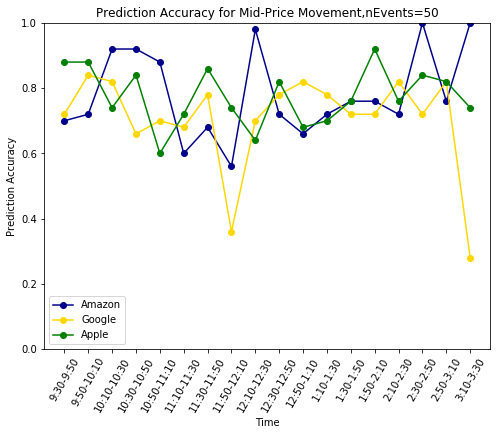

In [11]:
### Make plots for visualization
fig,ax = plt.subplots(1,1,figsize=(8,6))

x = np.arange(len(times)-1)
ax.plot(x,test_accs_AMZN,marker='o',color='darkblue',label='Amazon')
ax.plot(x,test_accs_GOOG,marker='o',color='gold',label='Google')
ax.plot(x,test_accs_AAPL,marker='o',color='green',label='Apple')

ax.legend(frameon=True)
ax.set_ylabel('Prediction Accuracy')
ax.set_xlabel('Time')
plt.title('Prediction Accuracy for Mid-Price Movement,nEvents=50')

labels = times
plt.xticks(x,labels,rotation=60)

plt.ylim([0,1])
plt.show()

In [12]:
t = time.time()
### find relations between nEvents and average prediction accuracies
nEvents_list = [5,10,15,20,50,100]
AMZNs, GOOGs, AAPLs = [], [], []
AMZNstd, GOOGstd, AAPLstd = [], [], []

for e in nEvents_list:
    # make prediciton
    test_accs_AMZN = PredictY_balancedTrainingSet(df_AMZN,20,nEvents=e,target_Y='MidPrice_Moves',C_param=0.1)
    test_accs_GOOG = PredictY_balancedTrainingSet(df_GOOG,20,nEvents=e,target_Y='MidPrice_Moves',C_param=0.1)
    test_accs_AAPL = PredictY_balancedTrainingSet(df_AAPL,20,nEvents=e,target_Y='MidPrice_Moves',C_param=0.1)
    # store average accuracies
    AMZNs.append(sum(test_accs_AMZN)/len(test_accs_AMZN))
    GOOGs.append(sum(test_accs_GOOG)/len(test_accs_GOOG))
    AAPLs.append(sum(test_accs_AAPL)/len(test_accs_AAPL))
    # store standard deviation
    AMZNstd.append(np.std(test_accs_AMZN))
    GOOGstd.append(np.std(test_accs_GOOG))
    AAPLstd.append(np.std(test_accs_AAPL))
##
print('processing time is {0:.2f} seconds.'.format(time.time()-t))

processing time is 223.00 seconds.


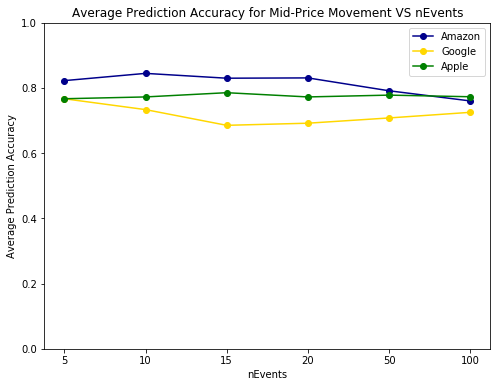

In [13]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
x = np.arange(len(nEvents_list))
ax.plot(x,AMZNs,marker='o',color='darkblue',label='Amazon')
ax.plot(x,GOOGs,marker='o',color='gold',label='Google')
ax.plot(x,AAPLs,marker='o',color='green',label='Apple')
ax.legend(frameon=True)
ax.set_ylabel('Average Prediction Accuracy')
ax.set_xlabel('nEvents')
plt.title('Average Prediction Accuracy for Mid-Price Movement VS nEvents')
labels = nEvents_list
plt.xticks(x,labels,rotation=0)
plt.ylim([0,1])
plt.show()

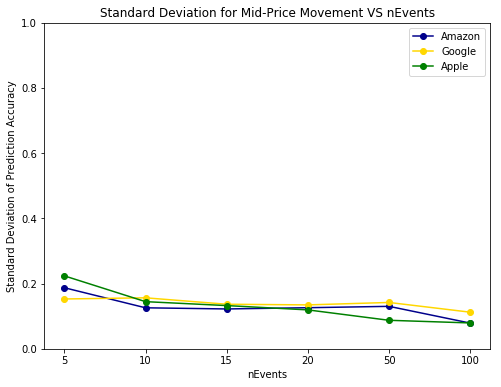

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
x = np.arange(len(nEvents_list))
ax.plot(x,AMZNstd,marker='o',color='darkblue',label='Amazon')
ax.plot(x,GOOGstd,marker='o',color='gold',label='Google')
ax.plot(x,AAPLstd,marker='o',color='green',label='Apple')
ax.legend(frameon=True)
ax.set_ylabel('Standard Deviation of Prediction Accuracy')
ax.set_xlabel('nEvents')
plt.title('Standard Deviation for Mid-Price Movement VS nEvents')
labels = nEvents_list
plt.xticks(x,labels,rotation=0)
plt.ylim([0,1])
plt.show()

### Implement a Trading Strategy

In [3]:
def ComputeOneDayNaturalGrowth(tradingDay_df,startMoney,startShares):
    # make a copy of the dataframe
    df = tradingDay_df.copy(deep=False)
    # get market prices at the start/end of this trading day
    P1 = (float(df.head(1).P_bid_1_.values) + float(df.head(1).P_ask_1_.values))/2
    P2 = (float(df.tail(1).P_bid_1_.values) + float(df.tail(1).P_ask_1_.values))/2
    # compute net worth at start/end of this trading day
    W1 = startMoney + startShares*P1
    W2 = startMoney + startShares*P2
    return (W2-W1)*100/W1

def PredictY_randomGuessing(tradingDay_df,trainingTime_mins,startMoney,startShares):
    # make a copy of the dataframe
    df = tradingDay_df.copy(deep=False)
    # use some indices to keep track
    money = float(startMoney)
    shares = float(startShares)
    start_worth = money + shares*float(df.head(1).P_bid_1_.values)
    NetWorths = [start_worth]
    Times = [float(df.head(1).Time_stamp.values)]
    # specify start time and end time of each training session
    st_time,ed_time  = int(list(df['Time_stamp'])[0]), int(list(df['Time_stamp'])[-1])  # in seconds
    ## st: denote the start time of each training session; lag: how much time allowed to fetch from the future
    lag = 5
    st, ed = st_time, st_time + trainingTime_mins*60
    # when last prediction time is not beyond the total trading time window
    while (ed+lag*60<=ed_time):
        # 1) original training set
        train = df[(df['Time_stamp']>=st)&(df['Time_stamp']<ed)]
        currentBid = float(train.tail(1).P_bid_1_.values)
        currentAsk = float(train.tail(1).P_ask_1_.values)
        currentMarket = (currentBid+currentAsk)/2
        #---------------------------------------#
        ## execute our buy or sell based on random guessing
        coin = randint(1,100)%2
        # case 1: predict ups
        if coin == 1:
            # use half of the money at hands to buy max shares
            if money > 0:
                shares += (float(money)/2)/currentAsk
                money = float(money)/2
                # update our 'account'
                NetWorths.append(money+shares*currentMarket)
                Times.append(float(train.tail(1).Time_stamp.values))
        # case 2: predict downs
        else: 
            # sell half shares at hand
            if shares > 0:
                money += float(shares/2)*currentBid
                shares = float(shares)/2
                # update our 'account'
                NetWorths.append(money+shares*currentMarket)
                Times.append(float(train.tail(1).Time_stamp.values))
        ### moving the training session forward
        st += trainingTime_mins * 60
        ed += trainingTime_mins * 60
        
    ## calculate net-gains (at the end of trading day) and return that value 
    end_marketP = (float(df.iloc[-1:,:].P_bid_1_.values) + float(df.iloc[-1:,:].P_ask_1_.values))/2
    End_worth, End_time = money+shares*end_marketP, float(df.iloc[-1:,:].Time_stamp.values) 
    NetWorths.append(End_worth)
    Times.append(End_time)
    #---------------------------------------#
    return money,shares,End_worth-start_worth,NetWorths,Times

def PredictY_buyStocks(tradingDay_df,trainingTime_mins,nEvents,target_Y,C_param,startMoney,startShares,threshold,prt):
    # make a copy of the dataframe
    df = tradingDay_df.copy(deep=False)
    # use some indices to keep track
    money= float(startMoney)
    shares = float(startShares)
    start_worth = money + shares*float(df.head(1).P_bid_1_.values)
    NetWorths = [start_worth]
    Times = [float(df.head(1).Time_stamp.values)]
    ###
    if prt:
        print('---> Hey, happy trading with ${} and {} shares.'.format(money,shares))
        print('---> You have ${} much of money to begin.\n'.format(start_worth,4))
    # specify start time and end time of each training session
    st_time,ed_time  = int(list(df['Time_stamp'])[0]), int(list(df['Time_stamp'])[-1])  # in seconds
    ## st: denote the start time of each training session; lag: how much time allowed to fetch from the future
    lag = 5
    st, ed = st_time, st_time + trainingTime_mins*60
    # when last prediction time is not beyond the total trading time window
    while (ed+lag*60<=ed_time):
        # 1) original training set
        train = df[(df['Time_stamp']>=st)&(df['Time_stamp']<ed)]
        # extract observations in training set, where y = 0/1/2
        train_y0 = train[(train[target_Y]==0)]
        train_y1 = train[(train[target_Y]==1)]
        train_y2 = train[(train[target_Y]==2)]
        # want to keep y0:y1:y2 = 1:1:2
        avg_y0y1 = int(float(train_y0.shape[0] + train_y1.shape[1])/2)
        train_y2_new = train_y2.sample(avg_y0y1*2)
        # concat the dataframe to make a new training set
        train_new = pd.concat([train_y0,train_y1,train_y2_new])
        # 2) use next nEvents to define testing set
        idx = int(df[(df['Time_stamp']>=ed)].head(1).index.values)
        test = df.iloc[idx+train.shape[0]:idx+train.shape[0]+nEvents]
        if idx+train.shape[0]+nEvents >= int(len(df.index)):
            break
        # 3) extract x and y variables in training set and testing set
        Xtrain = np.array(train_new[train_new.columns.difference
                                    (['OrderID','Time','Time_stamp','MidPrice_Moves','SpdCros_Moves','Label'])])
        ytrain = np.array(train_new[[target_Y]])
        Xtest = np.array(test[test.columns.difference
                                    (['OrderID','Time','Time_stamp','MidPrice_Moves','SpdCros_Moves','Label'])])
        ytest = np.array(test[[target_Y]])
        # train a model
        lr = LogisticRegression(penalty='l2',C=C_param,random_state=0)
        lr.fit(Xtrain,ytrain)
        # Report testing accuracy 
        testing_accuracy = lr.score(Xtest,ytest)
        #---------------------------------------#
        ## execute our buy or sell iff prediction accuracy > threshold
        if testing_accuracy > threshold:
            currentBid = float(train.tail(1).P_bid_1_.values)
            currentAsk = float(train.tail(1).P_ask_1_.values)
            currentMarket = (currentBid+currentAsk)/2
            # check, if we predict more ups / more downs
            y_true, y_pred = ytest,lr.predict(Xtest)
            cMatrix = pd.DataFrame(confusion_matrix(y_true,y_pred))
            if cMatrix.shape == (3,3):
                # case 1: predict more ups
                if sum(cMatrix[0].tolist()) > sum(cMatrix[1].tolist()):  # 0: upward; 1: downward
                    # use half of the money at hands to buy max shares
                    if money > 0:
                        shares += (float(money)/2)/currentAsk
                        money = float(money)/2
                        # update our 'account'
                        NetWorths.append(money+shares*currentMarket)
                        Times.append(float(train.tail(1).Time_stamp.values))
                        if prt:
                            print('time {0:.4f}: '.format(float(train.tail(1).Time_stamp.values)))
                            print('after buying, we have ${} and {} shares, worth ${}.'
                                 .format(np.round(money,2),np.round(shares,2),
                                         np.round(money+shares*currentMarket,2)))
                            print('current market price:$',currentMarket,'\n')
                # case 2: predict more downs    
                if sum(cMatrix[0].tolist()) < sum(cMatrix[1].tolist()):
                    # sell half shares at hand
                    if shares > 0:
                        money += float(shares/2)*currentBid
                        shares = float(shares)/2
                        # update our 'account'
                        NetWorths.append(money+shares*currentMarket)
                        Times.append(float(train.tail(1).Time_stamp.values))
                        if prt:
                            print('time {0:.4f}: '.format(float(train.tail(1).Time_stamp.values)))
                            print('after selling, we have ${} and {} shares, worth ${}.'
                                 .format(np.round(money,2),np.round(shares,2),
                                      np.round(money+shares*currentMarket,2)))
                            print('current market price:$',currentMarket,'\n')

        ### moving the training session forward
        st += trainingTime_mins * 60
        ed += trainingTime_mins * 60
        
    ## calculate net-gains (at the end of trading day) and return that value 
    end_marketP = (float(df.iloc[-1:,:].P_bid_1_.values) + float(df.iloc[-1:,:].P_ask_1_.values))/2
    End_worth, End_time  = money+shares*end_marketP, float(df.iloc[-1:,:].Time_stamp.values) 
    NetWorths.append(End_worth)
    Times.append(End_time)
    
    if prt:
        print('---> You end with ${} and {} shares.'.format(np.round(money,2),np.round(shares,2)))
        print('End worth and stock price: ',
              np.round(End_worth,2),np.round(end_marketP,2))
        print('\n---> Wow, you\'ve earned ${} by today; growth by {}%.'
              .format(np.round(NetWorths[-1]-NetWorths[0],2),np.round((NetWorths[-1]-NetWorths[0])*100/NetWorths[0],2)))
    #---------------------------------------#
    return money,shares,End_worth-start_worth,NetWorths,Times

#### Testing Amazon

In [4]:
### Testing Amazon
m,s,gains,trade_hist,times = PredictY_buyStocks(df_AMZN,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1,
                        startMoney=5000,startShares=200,threshold=0.75,prt=True)

---> Hey, happy trading with $5000.0 and 200.0 shares.
---> You have $49762.0 much of money to begin.

time 35399.7384: 
after selling, we have $27374.0 and 100.0 shares, worth $49762.0.
current market price:$ 223.88 

time 37799.7958: 
after buying, we have $13687.0 and 161.11 shares, worth $49763.94.
current market price:$ 223.93 

time 38999.7274: 
after selling, we have $31744.81 and 80.55 shares, worth $49807.85.
current market price:$ 224.235 

time 40199.9914: 
after buying, we have $15872.4 and 151.21 shares, worth $49833.67.
current market price:$ 224.595 

time 44999.0100: 
after selling, we have $32652.3 and 75.61 shares, worth $49437.49.
current market price:$ 222.01 

time 49798.0025: 
after buying, we have $16326.15 and 149.22 shares, worth $49410.4.
current market price:$ 221.715 

time 50997.0813: 
after buying, we have $8163.08 and 186.1 shares, worth $49346.63.
current market price:$ 221.3 

time 53399.4806: 
after buying, we have $4081.54 and 204.49 shares, worth $49

In [5]:
endP, startP = float(df_AMZN.tail(1).Mid_price.values),float(df_AMZN.head(1).Mid_price.values)
print('stock price has grown by {}%.'.format(np.round((endP-startP)*100/startP),3))

stock price has grown by -1.0%.


In [6]:
nat_grw = ComputeOneDayNaturalGrowth(df_AMZN,startMoney=5000,startShares=200)
print('natural growth of today is {}%.'.format(np.round(nat_grw,2)))

natural growth of today is -1.33%.


In [7]:
m2,s2,gains2,trade_hist2,times2 = PredictY_randomGuessing(df_AMZN,20,startMoney=5000,startShares=200)
print('in random guessing, you\'ve earned ${} by today; growth by {}%.'
      .format(np.round(trade_hist2[-1]-trade_hist2[0],2),
              np.round((trade_hist2[-1]-trade_hist2[0])*100/(trade_hist2[0]),2)))

in random guessing, you've earned $-466.06 by today; growth by -0.94%.


In [8]:
randomGuess_pct = []
for i in range(100):
    m2,s2,gains2,trade_hist2,times2 = PredictY_randomGuessing(df_AMZN,20,startMoney=5000,startShares=200)
    randomGuess_pct.append(np.round((trade_hist2[-1]-trade_hist2[0])*100/(trade_hist2[0]),2))
print('Average {} iterations, growth of random guessing is {}%'
      .format(len(randomGuess_pct),np.round(sum(randomGuess_pct)/len(randomGuess_pct),2)))

Average 100 iterations, growth of random guessing is -0.87%


C:\Users\Aaron\OneDrive\Documents\GitHub\Capstone_IEOR2017\FinalProject\matplotlibrc


Text(0.5,1,'Compare Stock Price and Net Worth, Amazon')

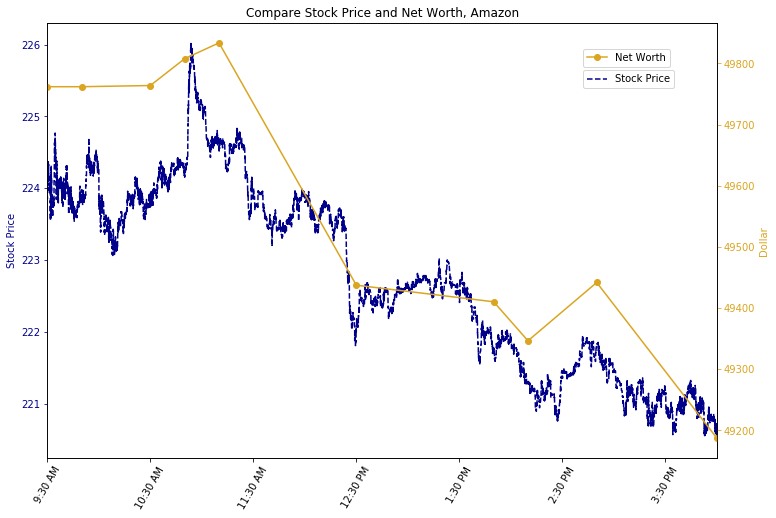

In [9]:
import matplotlib
print(matplotlib.matplotlib_fname())

fig, ax1 = plt.subplots(1,1,figsize=(12,8))
c1, c2 = 'darkblue','goldenrod'

x1 = list(df_AMZN.Time_stamp.values)  # 34200,34200.05,342000.08,.....57599
y1 = list(df_AMZN.Mid_price.values)
ax1.set_xlim(min(x1),max(x1))
l1 = ax1.plot(x1,y1,'--',color=c1,label='Stock Price')
ax1.set_ylabel('Stock Price',color=c1)
ax1.tick_params('y',colors=c1)
plt.legend(loc=[0.8,0.85], fontsize = 'medium')

x2 = times
y2 = trade_hist
ax2 = ax1.twinx()
l2 = ax2.plot(x2,y2,color=c2,label='Net Worth',marker='o')
ax2.set_ylabel('Dollar',color=c2)
ax2.tick_params('y',colors=c2)
plt.legend(loc=[0.8,0.9], fontsize = 'medium')

plt.xticks(np.arange(min(x1),max(x1)+1,3600))
ax1.set_xticklabels(('9:30 AM','10:30 AM','11:30 AM','12:30 PM','1:30 PM','2:30 PM','3:30 PM'),rotation=60)

plt.title('Compare Stock Price and Net Worth, Amazon')

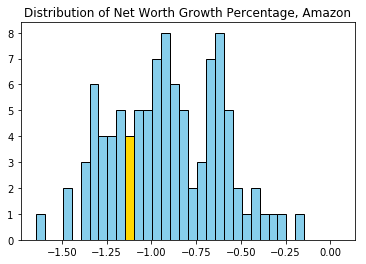

In [14]:
## histogram
n,bins,patches = plt.hist(randomGuess_pct,bins=np.arange(min(randomGuess_pct),max(randomGuess_pct),0.05),
                         align='left',color='skyblue',edgecolor='black')
patches[10].set_fc('gold')
plt.title('Distribution of Net Worth Growth Percentage, Amazon')
plt.show()

#### Testing Google

In [15]:
### Testing Google
# check and drop nan values if necessary
if df_GOOG.isnull().values.any():
    df_GOOG = df_GOOG.dropna()
m,s,gains,trade_hist,times = PredictY_buyStocks(df_GOOG,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1,
                        startMoney=5000,startShares=200,threshold=0.75,prt=True)

---> Hey, happy trading with $5000.0 and 200.0 shares.
---> You have $120880.0 much of money to begin.

time 36599.0010: 
after selling, we have $62513.0 and 100.0 shares, worth $120049.5.
current market price:$ 575.365 

time 37799.7830: 
after selling, we have $91285.5 and 50.0 shares, worth $120063.5.
current market price:$ 575.56 

time 42597.7000: 
after selling, we have $105582.75 and 25.0 shares, worth $119882.0.
current market price:$ 571.97 

time 46199.6171: 
after buying, we have $52791.38 and 117.6 shares, worth $119816.93.
current market price:$ 569.96 

time 47397.8509: 
after selling, we have $86277.11 and 58.8 shares, worth $119766.37.
current market price:$ 569.56 

time 48596.1369: 
after selling, we have $102982.34 and 29.4 shares, worth $119692.28.
current market price:$ 568.38 

time 52199.8592: 
after selling, we have $111319.67 and 14.7 shares, worth $119658.4.
current market price:$ 567.275 

time 54598.4877: 
after buying, we have $55659.84 and 112.76 shares, w

In [16]:
endP, startP = float(df_GOOG.tail(1).Mid_price.values),float(df_GOOG.head(1).Mid_price.values)
print('stock price has grown by {}%.'.format(np.round((endP-startP)*100/startP),3))

stock price has grown by -3.0%.


In [20]:
nat_grw = ComputeOneDayNaturalGrowth(df_GOOG,startMoney=5000,startShares=200)
print('natural growth of today is {}%.'.format(np.round(nat_grw,2)))

natural growth of today is -2.42%.


In [18]:
m2,s2,gains2,trade_hist2,times2 = PredictY_randomGuessing(df_GOOG,20,startMoney=5000,startShares=200)
print('in random guessing, you\'ve earned ${} by today; growth by {}%.'
      .format(np.round(trade_hist2[-1]-trade_hist2[0],2),
              np.round((trade_hist2[-1]-trade_hist2[0])*100/(trade_hist2[0]),2)))

in random guessing, you've earned $-1615.07 by today; growth by -1.34%.


In [19]:
randomGuess_pct = []
for i in range(100):
    m2,s2,gains2,trade_hist2,times2 = PredictY_randomGuessing(df_GOOG,20,startMoney=5000,startShares=200)
    randomGuess_pct.append(np.round((trade_hist2[-1]-trade_hist2[0])*100/(trade_hist2[0]),2))
print('Average {} iterations, growth of random guessing is {}%'
      .format(len(randomGuess_pct),np.round(sum(randomGuess_pct)/len(randomGuess_pct),2)))

Average 100 iterations, growth of random guessing is -1.69%


Text(0.5,1,'Compare Stock Price and Net Worth, Google')

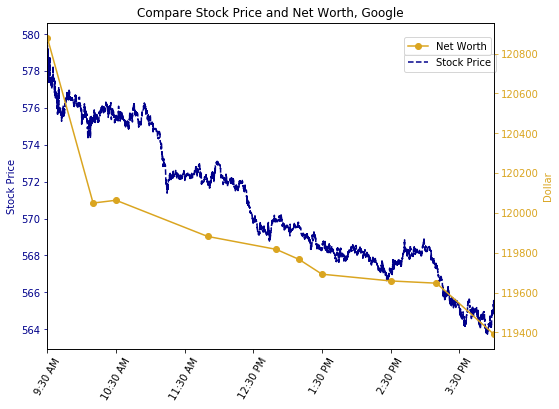

In [21]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
c1, c2 = 'darkblue','goldenrod'

x1 = list(df_GOOG.Time_stamp.values)  # 34200,34200.05,342000.08,.....57599
y1 = list(df_GOOG.Mid_price.values)
ax1.set_xlim(min(x1),max(x1))
l1 = ax1.plot(x1,y1,'--',color=c1,label='Stock Price')
ax1.set_ylabel('Stock Price',color=c1)
ax1.tick_params('y',colors=c1)
plt.legend(loc=[0.8,0.85], fontsize = 'medium')

x2 = times
y2 = trade_hist
ax2 = ax1.twinx()
l2 = ax2.plot(x2,y2,color=c2,label='Net Worth',marker='o')
ax2.set_ylabel('Dollar',color=c2)
ax2.tick_params('y',colors=c2)
plt.legend(loc=[0.8,0.9], fontsize = 'medium')

plt.xticks(np.arange(min(x1),max(x1)+1,3600))
ax1.set_xticklabels(('9:30 AM','10:30 AM','11:30 AM','12:30 PM','1:30 PM','2:30 PM','3:30 PM'),rotation=60)

plt.title('Compare Stock Price and Net Worth, Google')

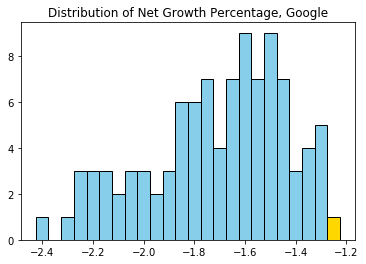

In [26]:
## histogram
n,bins,patches = plt.hist(randomGuess_pct,bins=np.arange(min(randomGuess_pct),max(randomGuess_pct),0.05),
                         align='left',color='skyblue',edgecolor='black')
patches[23].set_fc('gold')
plt.title('Distribution of Net Growth Percentage, Google')
plt.show()

#### Testing Apple

In [37]:
### Testing Apple
# check and drop nan values if necessary
if df_AAPL.isnull().values.any():
    df_AAPL = df_AAPL.dropna()
m,s,gains,trade_hist,times = PredictY_buyStocks(df_AAPL,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1,
                        startMoney=5000,startShares=200,threshold=0.75,prt=True)

---> Hey, happy trading with $5000.0 and 200.0 shares.
---> You have $122066.00000000001 much of money to begin.

time 35399.7364: 
after buying, we have $2500.0 and 204.27 shares, worth $122159.57.
current market price:$ 585.8 

time 36599.3256: 
after buying, we have $1250.0 and 206.4 shares, worth $122011.3.
current market price:$ 585.075 

time 37799.8373: 
after selling, we have $61694.12 and 103.2 shares, worth $122151.65.
current market price:$ 585.82 

time 38999.1209: 
after selling, we have $91975.52 and 51.6 shares, worth $122259.76.
current market price:$ 586.895 

time 42599.9143: 
after buying, we have $45987.76 and 130.22 shares, worth $122146.64.
current market price:$ 584.8399999999999 

time 46195.1145: 
after buying, we have $22993.88 and 169.66 shares, worth $121895.49.
current market price:$ 582.925 

time 49798.7305: 
after buying, we have $11496.94 and 189.39 shares, worth $121835.54.
current market price:$ 582.585 

time 50999.3438: 
after buying, we have $5748.

In [38]:
endP, startP = float(df_AAPL.tail(1).Mid_price.values),float(df_AAPL.head(1).Mid_price.values)
print('stock price has grown by {}%.'.format(np.round((endP-startP)*100/startP),3))

stock price has grown by -1.0%.


In [39]:
nat_grw = ComputeOneDayNaturalGrowth(df_AAPL,startMoney=5000,startShares=200)
print('natural growth of today is {}%.'.format(np.round(nat_grw,2)))

natural growth of today is -1.32%.


In [41]:
m2,s2,gains2,trade_hist2,times2 = PredictY_randomGuessing(df_AAPL,20,startMoney=5000,startShares=200)
print('in random guessing, you\'ve earned ${} by today; growth by {}%.'
      .format(np.round(trade_hist2[-1]-trade_hist2[0],2),
              np.round((trade_hist2[-1]-trade_hist2[0])*100/(trade_hist2[0]),2)))

in random guessing, you've earned $-482.06 by today; growth by -0.39%.


In [42]:
randomGuess_pct = []
for i in range(100):
    m2,s2,gains2,trade_hist2,times2 = PredictY_randomGuessing(df_AAPL,20,startMoney=5000,startShares=200)
    randomGuess_pct.append(np.round((trade_hist2[-1]-trade_hist2[0])*100/(trade_hist2[0]),2))
print('Average {} iterations, growth of random guessing is {}%'
      .format(len(randomGuess_pct),np.round(sum(randomGuess_pct)/len(randomGuess_pct),2)))

Average 100 iterations, growth of random guessing is -0.74%


Text(0.5,1,'Compare Stock Price and Net Worth, Apple')

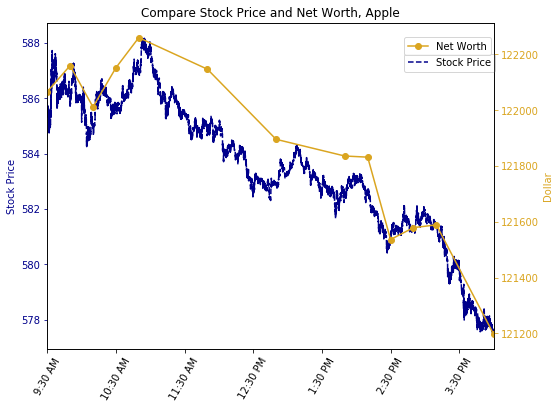

In [34]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
c1, c2 = 'darkblue','goldenrod'

x1 = list(df_AAPL.Time_stamp.values)  # 34200,34200.05,342000.08,.....57599
y1 = list(df_AAPL.Mid_price.values)
ax1.set_xlim(min(x1),max(x1))
l1 = ax1.plot(x1,y1,'--',color=c1,label='Stock Price')
ax1.set_ylabel('Stock Price',color=c1)
ax1.tick_params('y',colors=c1)
plt.legend(loc=[0.8,0.85], fontsize = 'medium')

x2 = times
y2 = trade_hist
ax2 = ax1.twinx()
l2 = ax2.plot(x2,y2,color=c2,label='Net Worth',marker='o')
ax2.set_ylabel('Dollar',color=c2)
ax2.tick_params('y',colors=c2)
plt.legend(loc=[0.8,0.9], fontsize = 'medium')

plt.xticks(np.arange(min(x1),max(x1)+1,3600))
ax1.set_xticklabels(('9:30 AM','10:30 AM','11:30 AM','12:30 PM','1:30 PM','2:30 PM','3:30 PM'),rotation=60)

plt.title('Compare Stock Price and Net Worth, Apple')

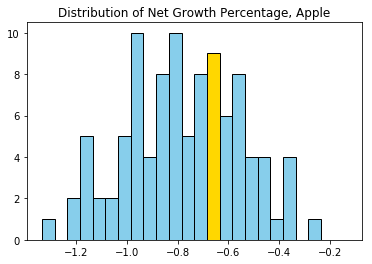

In [45]:
## histogram
n,bins,patches = plt.hist(randomGuess_pct,bins=np.arange(min(randomGuess_pct),max(randomGuess_pct),0.05),
                         align='left',color='skyblue',edgecolor='black')
patches[13].set_fc('gold')
plt.title('Distribution of Net Growth Percentage, Apple')
plt.show()